## TF tunner samples

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau
from processing import load_csv_data, slice_labels

Using TensorFlow backend.


In [3]:
from processing import load_image_dataset

x_rgb_train, y_rgb_train = load_image_dataset('Datasets/espe/masked/train', (40, 40), False)
x_rgb_test, y_rgb_test = load_image_dataset('Datasets/espe/masked/test', (40, 40), False)
x_rgb_validation, y_rgb_validation = load_image_dataset('Datasets/espe/masked/validation', (40, 40), False)

In [4]:
from processing import load_csv_data, slice_labels

train_path = 'Datasets/espe/lbp_histograms/train'
train_data = load_csv_data(train_path)

test_path = 'Datasets/espe/lbp_histograms/test'
test_data = load_csv_data(test_path)

validation_path = 'Datasets/espe/lbp_histograms/validation'
validation_data = load_csv_data(validation_path)

# train_data.shape, test_data.shape, validation_data.shape
x_train, y_train = slice_labels(train_data)
x_test, y_test = slice_labels(test_data)
x_val, y_val = slice_labels(validation_data)

In [5]:
import pandas as pd
test_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms/test/test.csv', header=None)[1:]
train_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms/train/train.csv', header=None)[1:]
val_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms/validation/validation.csv', header=None)[1:]

x_slhtt_test, y_slhtt_test = slice_labels(test_silhouette_dataset)
x_slhtt_train, y_slhtt_train = slice_labels(train_silhouette_dataset)
x_slhtt_val, y_slhtt_val = slice_labels(val_silhouette_dataset)

In [6]:
x_rgb_train.shape, x_train.shape

((463, 40, 40, 3), (463, 512))

In [7]:
x_rgb_validation.shape, x_val.shape

((103, 40, 40, 3), (103, 512))

In [53]:
from utils.Models import multi_input_model, lbp_histogram, lbp_image_classification,multi_input_model_color_silouethe
import datetime
loss_function = tf.keras.losses.CategoricalCrossentropy()

optimization_function = tf.keras.optimizers.Adam(lr=1e-3)

#Adam(lr=1e-3) -> mejor resultado para las imagenes a rgb
#RMSprop(lr=1e-3)

#model = multi_input_model_color_silouethe()
#model = lbp_histogram((512, ))
model =  lbp_image_classification((40, 40, 3))
model.compile(loss='categorical_crossentropy', optimizer=optimization_function, metrics=['acc'])

In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=8)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, min_delta=1e-2)
callbacks_list = [stop_early, reduce_lr]

In [55]:
#history = model.fit(x=[x_rgb_train], y=y_train, batch_size=200, epochs=30, validation_data=[[x_rgb_validation], y_val], callbacks=callbacks_list)
#HISTOGRAMA
#history = model.fit(x=[x_train], y=y_train, batch_size=300, epochs=30, validation_data=[[x_val], y_val], callbacks=callbacks_list)
#IMAGEN
history = model.fit(x=[x_rgb_train], y=y_train, batch_size=200, epochs=30, validation_data=[[x_rgb_validation], y_val], callbacks=callbacks_list)

Train on 463 samples, validate on 103 samples
Epoch 1/30
463/463 [==============================] - 1s 3ms/sample - loss: 51.2681 - acc: 0.2052 - val_loss: 58.1694 - val_acc: 0.1262
Epoch 2/30
463/463 [==============================] - 1s 1ms/sample - loss: 45.2055 - acc: 0.2289 - val_loss: 53.7685 - val_acc: 0.1650
Epoch 3/30
463/463 [==============================] - 1s 1ms/sample - loss: 35.5392 - acc: 0.4687 - val_loss: 27.4109 - val_acc: 0.4563
Epoch 4/30
463/463 [==============================] - 1s 2ms/sample - loss: 20.8469 - acc: 0.6004 - val_loss: 15.0291 - val_acc: 0.6214
Epoch 5/30
463/463 [==============================] - 1s 2ms/sample - loss: 6.7512 - acc: 0.6955 - val_loss: 14.6445 - val_acc: 0.4951
Epoch 6/30
463/463 [==============================] - 1s 2ms/sample - loss: 2.8177 - acc: 0.7516 - val_loss: 6.0888 - val_acc: 0.6505
Epoch 7/30
463/463 [==============================] - 1s 1ms/sample - loss: 1.1645 - acc: 0.8510 - val_loss: 6.3422 - val_acc: 0.7476
Epoch 8

In [50]:
import matplotlib.pyplot as plt

In [51]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


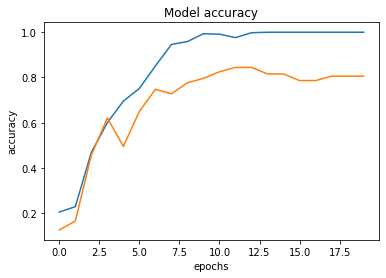

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('acc_1.png')

#azul = entrenamiento
#tomate = validacion

## Testing inference

In [57]:
#IMAGEN
model.evaluate(x=x_rgb_test, y=y_rgb_test, verbose=1)
# RMS: [4.671262875951902, 0.7676768]
# ADAM: [16.528304745452573, 0.72727275]
#histograma
#model.evaluate(x=x_test, y=y_test, verbose=1)
#RMSprop(lr=1e-3):[1.7638206373561511, 0.4040404] 0.4


99/99 [==============================] - 0s 656us/sample - loss: 6.5318 - acc: 0.7273


[6.531760051997021, 0.72727275]

## Saving model

In [ ]:
import os
checkpoint_path = "models/own/saved_model/my_model.h5"
model.save(checkpoint_path)

# Multi input model (lbp images, lbp histograms)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from processing import load_csv_data, slice_labels

In [ ]:
from processing import load_image_dataset

x_rgb_train, y_rgb_train = load_image_dataset('Datasets/espe/lbp_histograms - copia/train', (40, 40), True)
x_rgb_test, y_rgb_test = load_image_dataset('Datasets/espe/lbp_histograms - copia/test', (40, 40), True)
x_rgb_validation, y_rgb_validation = load_image_dataset('Datasets/espe/lbp_histograms - copia/validation', (40, 40), True)

In [ ]:
import pandas as pd
test_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms - copia/test/test.csv', header=None)[1:]
train_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms - copia/train/train.csv', header=None)[1:]
val_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms - copia/validation/validation.csv', header=None)[1:]

x_slhtt_test, y_slhtt_test = slice_labels(test_silhouette_dataset)
x_slhtt_train, y_slhtt_train = slice_labels(train_silhouette_dataset)
x_slhtt_val, y_slhtt_val = slice_labels(val_silhouette_dataset)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=8)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, min_delta=1e-2)
callbacks_list = [stop_early, reduce_lr]

In [ ]:
from utils.Models import multi_input_model
mi_model = multi_input_model()
mi_history = mi_model.fit(x=[x_slhtt_train, x_rgb_train], y=y_rgb_train, validation_data=[[x_slhtt_val, x_rgb_validation], y_rgb_validation], batch_size=100, epochs=60, callbacks=callbacks_list)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mi_history.history['acc'])
plt.plot(mi_history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### Silhouette identification

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from processing import load_csv_data, slice_labels

In [ ]:
import pandas as pd
from processing import slice_labels
test_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms - copia/test/test.csv', header=None)[1:]
train_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms - copia/train/train.csv', header=None)[1:]
val_silhouette_dataset = pd.read_csv('Datasets/espe/lbp_histograms - copia/validation/validation.csv', header=None)[1:]

x_slhtt_test, y_slhtt_test = slice_labels(test_silhouette_dataset)
x_slhtt_train, y_slhtt_train = slice_labels(train_silhouette_dataset)
x_slhtt_val, y_slhtt_val = slice_labels(val_silhouette_dataset)

In [ ]:
from utils.Models import silhouette_classifier_model
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=8)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, min_delta=1e-2)
callbacks_list = [stop_early, reduce_lr]
model = silhouette_classifier_model()
history = model.fit(x=[x_slhtt_train], y=y_slhtt_train, validation_data=[[x_slhtt_val], y_slhtt_val], batch_size=200, epochs=70, callbacks=callbacks_list)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model.evaluate(x=x_slhtt_test, y=y_slhtt_test, verbose=1)

In [ ]:
val = x_slhtt_test.iloc[1200:1202]
val

In [ ]:
y_slhtt_test[1200:1202]

In [ ]:
import tensorflow as tf
from utils.IdentificationModel import IDPath

model = tf.keras.models.load_model('models/own/saved_model/my_model.h5')
image = x_rgb_test[0].reshape(1, 40, 40, 1)
# prediction = model.predict(x=image)
model = IDPath()
model.identify(image)